Author: Cavin Gada

Description: In this project, I implement Principal Component Analysis and Dimensional Reduction from scratch by analyzing 157 face images and  reconstructing the remaining 20 using eigen decomposition.  

In [11]:
from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np

In [12]:

""" Data Pre-Processing """

# initialize train set & test set
train_set = np.empty((0,65536), int)
test_set = np.empty((0,65536), int)

# used glob with the help of the following resource: 
# https://www.codegrepper.com/code-examples/python/python+load+all+images+from+folder
count = 0
for face in glob.glob('face_data/*.bmp'):

    # open image and represent it as 1 x 65536 instead of 256 x 265 numpy array of 'pixels'
    img = Image.open(face) 
    oneD_data = np.reshape(np.asarray(img), (65536))    
    
    # split train and test sets [indices 0 to 156 (157 total) is train and indices 157 to 177 is test (20 total)]
    if count > 156:  
        test_set = np.append(test_set, np.array([oneD_data]), axis=0)
        
    else:
        train_set = np.append(train_set, np.array([oneD_data]), axis=0)

    count+=1

# returns the 1D vector representing the mean image. 
def getMeanImage(train):
    return train.sum(axis=0)/train.shape[0]

# store the mean image as a 'global' variable. We want to access this everywhere else
# and prevent unecessary re-computation 
meanImage = getMeanImage(train_set)

# subtract each training sample by the mean (center the train set about the mean)
for i in range(len(train_set)):
    train_set[i] = train_set[i] - meanImage

# subtract each test sample by the mean (center the test set about the mean)
for i in range(len(test_set)):
    test_set[i] = test_set[i] - meanImage


# acquire the covariance matrix (X*XT/n)
covarianceMatrix = np.matmul(train_set, train_set.T)/157

# compute eigenvectors
def getEigenvectors(covarianceMatrix):
    evalues, evectors= np.linalg.eig(covarianceMatrix)

    # sort eigenvectors by their corresponding eigenvalues (from max to min)
    # credit to following code (modified it slightly such that I only compute data I need):
    # https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
    
    i = evalues.argsort()[::-1]
    return evectors[:,i] 

# store eigenvectors in a 'global' variable to avoid unecessary re-computations. 
eigenVectors = getEigenvectors(covarianceMatrix).T

# returns n eigenfaces, in which each row is an eigenface. Dimensinos are n x 65536. 
def getEigenFaces(n, eigenVectors):

    # instantiate empty np array 
    eigenFaces = np.empty((n,65536), float)

    # iterate through each eigenvector and set each eigenface (ef_i) to the normalized vector of XT * v_i
    for i in range(n):
        eigenFaces[i] = np.matmul(train_set.T, eigenVectors[i])     # compute xT * v_i
        eigenFaces[i] = eigenFaces[i]/np.linalg.norm(eigenFaces[i]) # normalization (divide by magnitude)

    return eigenFaces


# assume facedata is 1 dimensional and is centered about the mean 
# returns a 1 x 65536 numpy array of reconstruction prediction data
def predictFace(faceData, eigenFaces):
    #x-x_bar * w
    pred = np.matmul(np.matmul(faceData, eigenFaces.T), eigenFaces)
    return pred + meanImage

# displays exactly 10 eigenfaces. Assumes eigenfaces input is exactly 10 eigenfaces. 
def displayEigenFaces(eigenfaces):

    #set a reasonable size to hold images on plot
    eigenFacePlot = plt.figure(figsize=(10,4)) 

    # iterate through each eigenface and add it to the plot. 
    # display 5 eigenfaces per row on the plot 
    for i in range(eigenfaces.shape[0]):
        eigenFacePlot.add_subplot(2, 5, i+1)    #this allows for displaying each image by rotating in a 'clockwise' manner around the plot
        plt.imshow(np.array(eigenfaces[i].reshape(256, 256)), cmap = 'gray')    #plot the eigenface
        plt.axis('off')                 
        plt.title('Eigenface ' + str(i+1) + ':')    #label the eigenface


# returns n comparisons (preferrably 5 due to plot formatting) between predictions of images and actual images. 
def comparePredictions(testSet, eigenFaces, n):

    predictionPlot = plt.figure(figsize=(12,4))

    # plot the actual images on row 1 
    for i in range(n):
        predictionPlot.add_subplot(2, 5, i+1)
        plt.imshow(np.array((testSet[i]+meanImage).reshape(256, 256)), cmap = 'gray')
        plt.axis('off')
        plt.title("Original Image " + str(i+1) + ":")

    # plot the predictions on row 2 (each prediction underneath its truth)
    for i in range(n):
        predictionPlot.add_subplot(2, 5, i+6) # the last five plots occupy positions 6, 7, 8, 9, 10 on the subplot. 

        prediction = predictFace(testSet[i], eigenFaces)

        plt.imshow(np.array(prediction.reshape(256, 256)), cmap = 'gray')
        plt.axis('off')
        plt.title("Predicted Image " + str(i+1) + ":")

# returns reconstruction error given eigenfaces and the test_set. This function is essentially a helper for displayError
def reconstructionError(testSet, eigenfaces):

    error = 0

    for y in testSet:
        y_pred = predictFace(y, eigenfaces) - meanImage # get the prediction (subtract mean image for accurate comparison to y, which is centered about mean)
        error+=(np.linalg.norm(y_pred-y) ** 2) / 20 #add the squared difference between the prediction and truth / sample size to the total error

    return error

def displayError(testSet):

    # initialize list of possible k values (number of eigenfaces) to compare (as suggested in part c).
    k_list = [10,30,50,100,150]

    # initialize corresponding error list. Each error at index i in the error list corresponds to the same index i in the k_list  
    error_list = []

    # store the maximum number of eigenfaces we will need to generate
    efs = getEigenFaces(max(k_list), eigenVectors)

    for k in k_list:
        efs_k = efs[:k, :] #store the number of eigenvalues we will use for the specific iteration
        error_list += [reconstructionError(testSet, efs_k)] #calculate the error and add it to the error list at its correct position. 

    # plot the results
    plt.plot(k_list, error_list)
    plt.xlabel('k (number of eigenfaces')
    plt.ylabel('Reconstruction Error')
    plt.title('Number of Eigenfaces vs Reconstruction Error')
    plt.show()


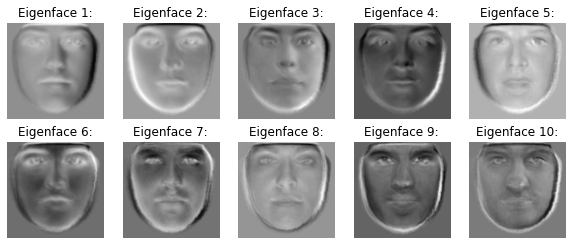

In [13]:
""" PART A """
thirty_eigenfaces = getEigenFaces(30, eigenVectors) # compute top 30 eigenfaces
ten_eigenfaces = thirty_eigenfaces[:10, :]          # store top 10 eigenfaces
displayEigenFaces(ten_eigenfaces)                   # display top 10 eigenfaces

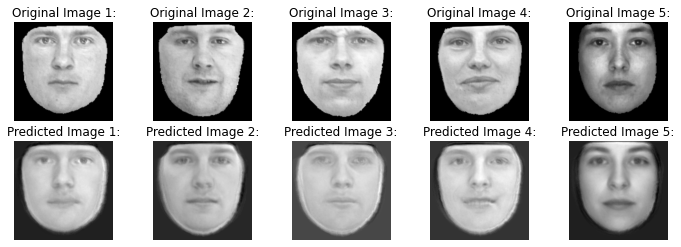

In [14]:
""" PART B """
comparePredictions(test_set, thirty_eigenfaces, 5) # display five predictions with their corresponding true image using 30 eigenvalues

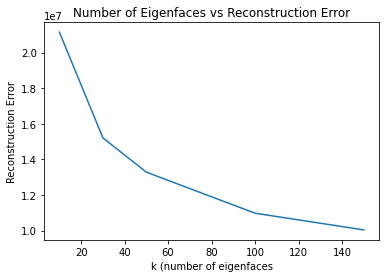

In [15]:
""" PART C *this may take around 10-15s to run """
displayError(test_set)  # display error on the test_set at k = 10 to 150